In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [105]:
# reading data from csv file locally
df = spark.read.format("csv").option("header", "true").load("income_and_expenditure.csv")

In [106]:
df.count()

303

In [107]:
df.show(5)

+------+-----+
|INCOME|SPEND|
+------+-----+
|   233|  150|
|   250|  187|
|   204|  172|
|   236|  178|
|   354|  163|
+------+-----+
only showing top 5 rows



In [108]:
df.printSchema()

root
 |-- INCOME: string (nullable = true)
 |-- SPEND: string (nullable = true)



In [109]:
# changing columns datatype to int 
df = df.withColumn("INCOME", df["INCOME"].cast('int')).withColumn("SPEND", df["SPEND"].cast('int'))

In [110]:
df.printSchema()

root
 |-- INCOME: integer (nullable = true)
 |-- SPEND: integer (nullable = true)



In [111]:
# checking for null values
df.createOrReplaceTempView('temp_df')
my_df = spark.sql("select * from temp_df where INCOME=NULL or SPEND=NULL")
my_df.show()

+------+-----+
|INCOME|SPEND|
+------+-----+
+------+-----+



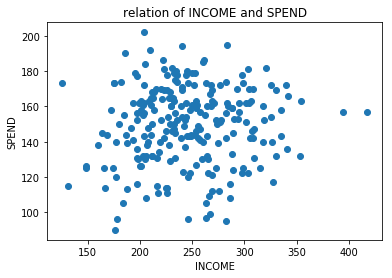

In [112]:
# sampling and plotting the dataframe
import pandas as pd
import matplotlib.pyplot as plt
x='INCOME'
y='SPEND'
sampled_data = df.select(x,y).sample(False, 0.8).toPandas()
plt.scatter(sampled_data.INCOME,sampled_data.SPEND)
plt.xlabel(x)
plt.ylabel(y)
plt.title('relation of INCOME and SPEND')
plt.show()

In [113]:
# assembling the columns
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = [x,y], outputCol = 'features')
v_df = vectorAssembler.transform(df)
v_df = v_df.select(['features'])
v_df.show(3)

+-------------+
|     features|
+-------------+
|[233.0,150.0]|
|[250.0,187.0]|
|[204.0,172.0]|
+-------------+
only showing top 3 rows



In [90]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [114]:
# creating objects with four centers and fitting
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(v_df)

In [115]:
# predicting centers
predictions = model.transform(v_df)

In [116]:
predictions.show(5)

+-------------+----------+
|     features|prediction|
+-------------+----------+
|[233.0,150.0]|         2|
|[250.0,187.0]|         2|
|[204.0,172.0]|         0|
|[236.0,178.0]|         2|
|[354.0,163.0]|         3|
+-------------+----------+
only showing top 5 rows



In [117]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.462751619670138


In [118]:
# Shows the center points
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[192.76086957 148.57608696]
[285.81081081 141.09459459]
[240.45132743 155.79646018]
[344.29166667 151.16666667]


In [119]:
predictions.select('features').show(5)

+-------------+
|     features|
+-------------+
|[233.0,150.0]|
|[250.0,187.0]|
|[204.0,172.0]|
|[236.0,178.0]|
|[354.0,163.0]|
+-------------+
only showing top 5 rows



In [97]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

In [120]:
split1_udf = udf(lambda value: value[0].item(), FloatType())
split2_udf = udf(lambda value: value[1].item(), FloatType())

In [121]:
# unpacking features column so that we can plot them 
predictions=predictions.withColumn('x', split1_udf('features')).withColumn('y', split2_udf('features'))

In [122]:
predictions.show(4)

+-------------+----------+-----+-----+
|     features|prediction|    x|    y|
+-------------+----------+-----+-----+
|[233.0,150.0]|         2|233.0|150.0|
|[250.0,187.0]|         2|250.0|187.0|
|[204.0,172.0]|         0|204.0|172.0|
|[236.0,178.0]|         2|236.0|178.0|
+-------------+----------+-----+-----+
only showing top 4 rows



In [123]:
# sampling data to plot 
data = predictions.select('x','y','prediction').sample(False, 0.8).toPandas()

In [124]:
x_cord = [[],[],[],[]]
y_cord = [[],[],[],[]]

In [128]:
cx = []
cy = []
for center in model.clusterCenters():
    cx.append(center[0])
    cy.append(center[1])

In [129]:
for i in range(len(data)):
    x_cord[data.loc[i,'prediction']].append(data.loc[i,'x'])
    y_cord[data.loc[i,'prediction']].append(data.loc[i,'y'])

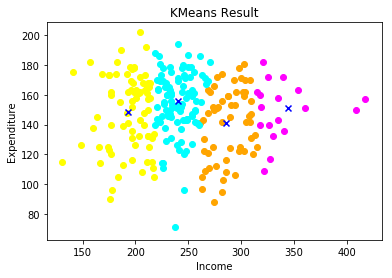

In [133]:
# plotting the clusters
plt.scatter(x_cord[0],y_cord[0],c='yellow')
plt.scatter(x_cord[1],y_cord[1],c='orange')
plt.scatter(x_cord[2],y_cord[2],c='cyan')
plt.scatter(x_cord[3],y_cord[3],c='magenta')
plt.scatter(cx,cy,c='blue',marker='x')
plt.xlabel('Income')
plt.ylabel('Expenditure')
plt.title('KMeans Result')
plt.show()colors

### You can clearly see four clusters with centers in blue colors